# Support Ticket Triage Graph - Walkthrough

This notebook demonstrates the LangGraph-based support ticket triage system.

## What it does
- Takes an Intercom support ticket
- Classifies it as frontend/backend/infra/unclear
- Fetches recent GitHub PRs and Linear tickets
- Correlates the ticket with recent changes
- Generates actionable recommendations for support team

In [1]:
# Setup
import os
from dotenv import load_dotenv

load_dotenv()

# Enable LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.environ.get("LANGSMITH_PROJECT", "triage-graph")
print(f"LangSmith tracing enabled (project: {os.environ['LANGCHAIN_PROJECT']})")

# Load mock data (uses proprietary data if available, otherwise public)
from src.main import load_mock_data
mock_data = load_mock_data()

print(f"Loaded {len(mock_data['tickets'])} mock tickets")

LangSmith tracing enabled (project: graph-assignment)
Using proprietary mock data: data/proprietary/mock_intercom.yaml
Loaded 10 mock tickets


## Graph Architecture

The triage workflow uses a **fan-out/fan-in** pattern:
1. **Intake** validates the ticket
2. **Classify** determines if it's frontend/backend/infra (LLM)
3. **Fetch** agents query GitHub, Linear, and Intercom in parallel
4. **Analyze** correlates the ticket with recent changes (LLM)
5. **Route** based on confidence (may retry with wider time window)
6. **Recommend** a single next action for support (LLM)
7. **Verify** the output is valid

**Color Legend:**
- 🔵 Blue = Orchestrator nodes (LLM-powered)
- 🟠 Orange = Tool agents (API calls)
- 🟣 Purple = Decision/loop node

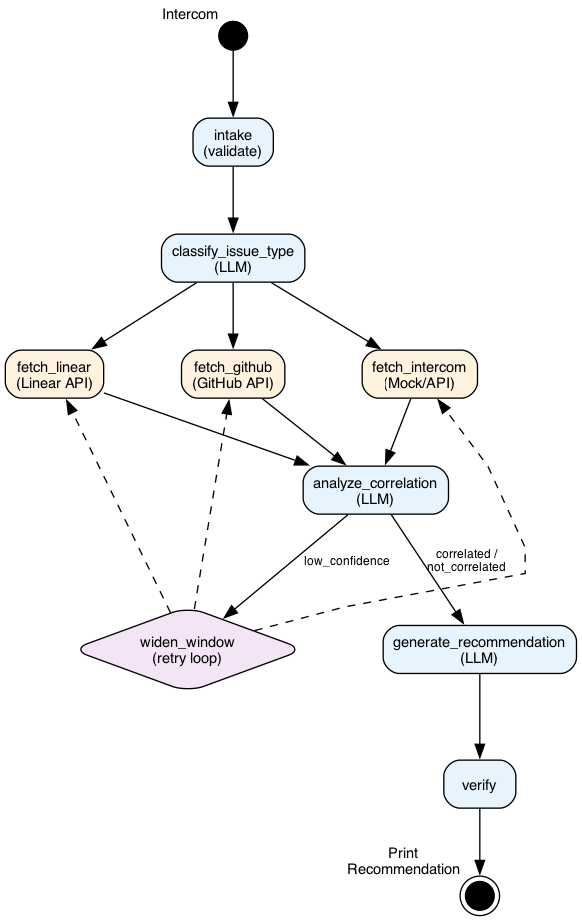

In [2]:
# Display the graph
from IPython.display import Image
from src.visualization import get_graph_image

Image(get_graph_image())

In [3]:
# Initialize the system
from langchain_ollama import ChatOllama
from src.providers import MockIntercomProvider
from src.nodes import init_dependencies
from src.graph import create_triage_app

# Create provider and LLM
intercom_provider = MockIntercomProvider(mock_data)
llm = ChatOllama(model="llama3.2")

# Initialize dependencies
init_dependencies(intercom_provider, llm)

# Create the graph app
app = create_triage_app()

print("Triage app ready!")

Triage app ready!


In [4]:
# View available mock tickets
print("Available mock tickets:")
print("-" * 50)
for tid, ticket in mock_data["tickets"].items():
    print(f"{tid}: {ticket['subject']}")

Available mock tickets:
--------------------------------------------------
ticket-001: Contacts page taking forever to load
ticket-002: Are there deployment issues? App seems unstable
ticket-003: Getting 503 errors this morning
ticket-004: Premise contacts list is broken
ticket-005: Cannot view contacts on premises
ticket-006: How do I export premises to Excel?
ticket-007: Adding custom fields to contacts
ticket-008: App performance degraded after update
ticket-009: Request: Dark mode support
ticket-010: Contacts timeout on large premises


In [6]:
# Run triage on a ticket
ticket = intercom_provider.fetch_ticket("ticket-002")
print(f"Processing ticket:")
print(f"  Subject: {ticket['subject']}")
print(f"  Body: {ticket['body']}")
print()
print("Running triage...")
print("=" * 50)

initial_state = {"ticket": ticket, "reference_date": "2026-01-26"}
result = app.invoke(initial_state)

print("\nTriage complete!")

20:50:29 [intake] ============================================================
20:50:29 [intake] Processing new ticket
20:50:29 [intake] Subject: Are there deployment issues? App seems unstable
20:50:29 [intake] Body: We noticed some weird behavior starting around Jan 22. Sometimes pages fail to load completely, and ...
20:50:29 [classify] ------------------------------------------------------------
20:50:29 [classify] Determining issue type with LLM
20:50:29 [classify] Calling LLM...


Processing ticket:
  Subject: Are there deployment issues? App seems unstable
  Body: We noticed some weird behavior starting around Jan 22. Sometimes pages fail to load completely, and we see occasional 502 errors. Is there something going on with your infrastructure? Our team has reported this across multiple browsers.

Running triage...


20:50:30 [httpx] HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
20:50:30 [classify] Result: infra
20:50:30 [classify] Reasoning: The ticket mentions deployment issues and infrastructure problems, indicating a problem with the underlying systems rather than UI or API-specific errors.
20:50:30 [classify] Target repos: ['livsafe/liv-infra-terraform']
20:50:30 [fetch_github] ------------------------------------------------------------
20:50:30 [fetch_intercom] ------------------------------------------------------------
20:50:30 [fetch_intercom] Fetching recent tickets
20:50:30 [fetch_linear] ------------------------------------------------------------
20:50:30 [fetch_github] Fetching merged PRs
20:50:30 [fetch_github] Time window: 1 day(s) from 2026-01-26
20:50:30 [fetch_github] Target repos: ['livsafe/liv-infra-terraform']
20:50:30 [fetch_intercom] Time window: 1 day(s)
20:50:30 [fetch_intercom] Found 0 tickets
20:50:30 [fetch_linear] Fetching deployed tickets
20:50


TRIAGE COMPLETE
Ticket: Are there deployment issues? App seems unstable
Classification: infra
Next Action: ESCALATE
Reason: The correlation with the recent code change and recurring pattern suggest that the issue is likely related to the deployment of INF-172, which occurred on Jan 23.
Tags: tag1, tag2
Correlation: Correlation between Jan 22 issue start date and INF-172 deployment on Jan 23
Matched Item: pr - INF-172: Granted Production pull access for docker-laravel registry
Questions for Customer: ['What are the specific browsers experiencing the issues?', 'Can you provide more details about the error messages?']
Engineering Context: Review of Terraform infrastructure changes and docker-laravel registry access


Triage complete!


In [ ]:
# View classification
print("CLASSIFICATION")
print("=" * 50)
print(f"Issue Type: {result['issue_type']}")
print(f"Target Repos: {result['target_repos']}")

In [ ]:
# View correlation analysis
print("CORRELATION ANALYSIS")
print("=" * 50)
correlation = result['correlation_result']
print(f"Correlated: {correlation['correlated']}")
print(f"Confidence: {correlation['confidence']}")
print(f"Type: {correlation['correlation_type']}")
print(f"Reason: {correlation['reason']}")

if correlation.get('matched_item'):
    print(f"\nMatched Item: {correlation['matched_item']}")

In [ ]:
# View recurring pattern detection
print("RECURRING PATTERN ANALYSIS")
print("=" * 50)
recurring = result.get('recurring_pattern', {})
print(f"Is Recurring: {recurring.get('is_recurring', False)}")
if recurring.get('related_tickets'):
    print(f"Related Tickets: {recurring['related_tickets']}")
if recurring.get('pattern_summary'):
    print(f"Pattern: {recurring['pattern_summary']}")

In [ ]:
# View final recommendation
print("TRIAGE RECOMMENDATION")
print("=" * 50)
rec = result['recommendation']

print(f"\nSuggested Tags: {rec['suggested_tags']}")
print(f"\nCorrelation Summary: {rec['correlation_summary']}")

# Show the single next action
action_labels = {
    "escalate": "ESCALATE TO ENGINEERING",
    "get_more_info": "ASK CUSTOMER FOR MORE INFO",
    "reproduce": "TRY TO REPRODUCE",
}
next_action = rec.get('next_action', 'unknown')

print(f"\n>>> NEXT ACTION: {action_labels.get(next_action, next_action)}")
print(f"    Reason: {rec.get('next_action_reason', 'N/A')}")

if next_action == "get_more_info" and rec.get("questions_for_customer"):
    print(f"\nQuestions to Ask Customer:")
    for q in rec["questions_for_customer"]:
        print(f"  - {q}")

if next_action == "escalate" and rec.get("engineering_context"):
    print(f"\nEngineering Context: {rec['engineering_context']}")

print(f"\n--- VERIFICATION ---")
print(f"Verified: {result['verified']}")